# Projectile motion solved with PINNs

In [1]:
# import necessery packages like pytorch, matplotlib and PIL
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [2]:
# Function for converting png plots files to animated gif - taken from this excelent github repository about PINNs
# https://github.com/benmoseley/harmonic-oscillator-pinn

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
# Projectile motion data generator - simple school solution of projectile motion.

def projectile_motion_gen(t, g, v_0, h_0, alpha):
    x = v_0 * torch.cos(alpha) * t
    y = h_0 + v_0 * torch.sin(alpha) * t + 0.5 * g * t**2
    return x.view(-1,1), y.view(-1,1)

In [4]:
# Neural network definition

class PM(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden_layer_1 = nn.Linear(n_hidden, n_hidden)
        self.hidden_layer_2 = nn.Linear(n_hidden, n_hidden)
        self.hidden_layer_3 = nn.Linear(n_hidden, n_hidden)
        self.hidden_layer_4 = nn.Linear(n_hidden, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.input_layer(x)
        x = torch.tanh(x)
        x = self.hidden_layer_1(x)
        x = torch.tanh(x)
        x = self.hidden_layer_2(x)
        x = torch.tanh(x)
        x = self.hidden_layer_3(x)
        x = torch.tanh(x)
        x = self.hidden_layer_4(x)
        x = torch.tanh(x)
        output_ = self.output_layer(x)
        return output_

In [5]:
# Training data generation where g - gravitational acceleration, v_0 - initial velocity, h_0 - initial heigh, alpha - between v_0 velocity vector and x-axis.
g = -9.81
v_0 = 6.5
h_0 = 1.5
alpha = torch.Tensor([torch.pi/3]) # pi/3 -> 60 degrees

# time domain
t = torch.linspace(0, 1.5, 100).view(-1,1)


x, y = projectile_motion_gen(t, g, v_0, h_0, alpha)

# Choosing data for NN training
x_data = x[0:40:8]
y_data = y[0:40:8]
t_data = t[0:40:8]

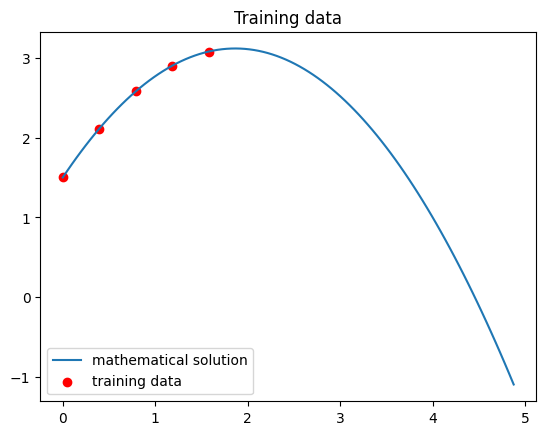

In [6]:
# Training data and mathematical solution visualisation

plt.figure()
plt.plot(x, y, label='mathematical solution')
plt.scatter(x_data, y_data, color='red', label='training data')
plt.legend()
plt.title('Training data')
plt.show()

In [7]:
# More plots

def plots_in_run(t, t_data, x, y, x_h, y_h, x_data, y_data, i, losses_p, losses_d):
    fig, axs = plt.subplots(2, 2, figsize=(9,9), constrained_layout=True)
    fig.suptitle(f'Projectile motion solved by PINN, step: {i + 1}')
    axs[0, 0].plot(t, x, color='gray', label = 'Mathematical solution')
    axs[0, 0].scatter(t_data, x_data, color='orange' ,label = 'Training data')
    axs[0, 0].plot(t, x_h, color='green', label = 'PINN result')
    axs[0, 0].set(xlabel='t', ylabel='x(t)')
    axs[0, 0].legend()
    axs[1, 0].plot(t, y, color='gray', label = 'Mathematical solution')
    axs[1, 0].scatter(t_data, y_data, color='orange' ,label = 'Training data')
    axs[1, 0].plot(t, y_h, color='green', label = 'PINN result')
    axs[1, 0].set(xlabel='t', ylabel='y(t)')
    axs[0, 1].plot(x, y, color='gray', label = 'Mathematical solution')
    axs[0, 1].scatter(x_data, y_data, color='orange' ,label = 'Training data')
    axs[0, 1].plot(x_h, y_h, color='green', label = 'PINN result')
    axs[0, 1].set(xlabel='x', ylabel='y')
    axs[1, 1].plot(losses_d, color='blue', label = 'Data loss')
    axs[1, 1].plot(losses_p, color='red', label = 'Physics loss')
    axs[1, 1].set(xlabel='i', ylabel='loss')
    axs[1, 1].legend()
    axs[1, 1].set_xticks([])
    

In [8]:
# Neural network initialization

model = PM(1, 2, 32)

t_physics = torch.linspace(0, 1.5, 20).view(-1, 1).requires_grad_(True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


# Training loop
epochs = 7000
losses_p = []
losses_d = []
files = []
for i in range(epochs):
    optimizer.zero_grad()
    
    # forward pass of training data and loss calculation
    z = model(t_data)
    x_h, y_h = z[:,[0]], z[:,[1]]
    loss_1 = torch.mean((x_h - x_data)**2) + torch.mean((y_h - y_data)**2)

    # forward pass for physics - gradients calculation and physics loss estimation
    z_p = model(t_physics)
    x_h_p, y_h_p = z_p[:,[0]], z_p[:,[1]]
    dx = torch.autograd.grad(x_h_p, t_physics, torch.ones_like(x_h_p), create_graph=True)[0]
    d2x = torch.autograd.grad(dx, t_physics, torch.ones_like(dx), create_graph=True)[0]
    dy = torch.autograd.grad(y_h_p, t_physics, torch.ones_like(y_h_p), create_graph=True)[0]
    d2y = torch.autograd.grad(dy, t_physics, torch.ones_like(dy), create_graph=True)[0]

    physics_x = d2x - 0
    physics_y = d2y - g

    loss_x = torch.mean(physics_x**2)
    loss_y = torch.mean(physics_y**2)
    loss_physics = loss_x + loss_y
    loss = loss_1 + 0.00075 * loss_y + 0.00075 * loss_x

    # backpropagation
    loss.backward()
    optimizer.step()

    losses_p.append(loss_physics.item())
    losses_d.append(loss_1.item())

    # png files generation
    if (i + 1) % 25 == 0:
        z_p = model(t).detach()
        x_h_p, y_h_p = z_p[:,[0]], z_p[:,[1]]
        
        plots_in_run(t, t_data, x, y, x_h_p, y_h_p, x_data, y_data, i, losses_p, losses_d)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i) % 1000 == 0: plt.show()
        else: plt.close("all")

# Animated gif generation
save_gif_PIL("pinn.gif", files, fps=20, loop=0)
